# Get Statistics

In [3]:
import numpy as np
from find_examples import CorpusExamples
import multiprocess as mp

Preparing corpus from /media/ducha/SSDSHARED/VN/subs_dump/viet_subs_processed2
Corpus prepared with 13646 files
Total Examples 7736833


In [ ]:
corpus_folder = "/media/ducha/SSDSHARED/VN/subs_dump/viet_subs_processed2"
corpus = CorpusExamples(corpus_folder)

In [14]:
def do_mp():
    def process_sentences(sentences_set):
        return [len(s.split()) for s in sentences_set]

    def process(corpus_split: np.array):
        result = []
        for _, sentences in corpus_split:
            result.extend(process_sentences(sentences))
        corpus.result_queue.put(result)

    # Create and start the processes
    processes = []

    for i in range(corpus.num_processes):
        split_corpus = corpus.corpus[
            i * corpus.split_size : (i + 1) * corpus.split_size
        ]

        p = mp.Process(target=process, args=(split_corpus,))
        p.start()
        processes.append(p)

    # Wait for all processes to finish
    for p in processes:
        p.join()

    # Collect the results from the Queue and concatenate them into a single list
    final_result = []
    while not corpus.result_queue.empty():
        final_result.extend(corpus.result_queue.get())

    return final_result

In [53]:
sentence_lengths = np.array(do_mp())
# np.savetxt("corpus_sentence_lengths.txt", sentence_lengts, fmt="%d")
# Get 90th percentile of the sentence lengths
lower_bound = np.percentile(sentence_lengths, 20)
upper_bound = np.percentile(sentence_lengths, 90)

lower_bound, upper_bound
# Remove Outliers
bounds = np.logical_and(lower_bound < sentence_lengths, sentence_lengths <= upper_bound)
sentence_lengths = sentence_lengths[bounds]
sentence_lengths.mean(), sentence_lengths.std(), sentence_lengths.min(), sentence_lengths.max(), sentence_lengths.shape

(7.381393065311473, 2.8782958648664723, 4, 15, (5336505,))

<Axes: ylabel='Count'>

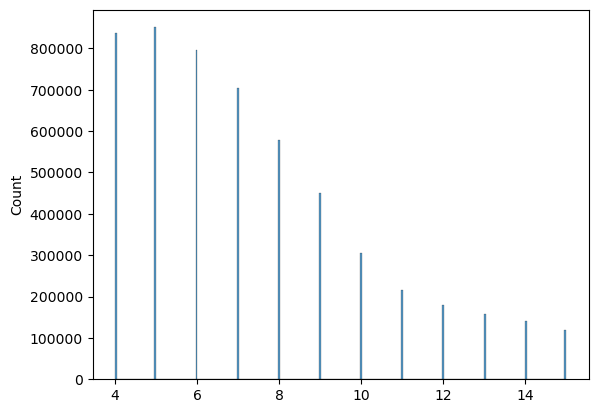

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(sentence_lengths)

In [77]:
bins = np.arange(
    sentence_lengths.min(), sentence_lengths.max() + 2
)  # Correct bin edges
sentence_distribution, hist_bins = np.histogram(
    sentence_lengths,
    bins=bins,
    density=True,
)

In [78]:
hist_bins, sentence_distribution.shape

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), (12,))

<Axes: >

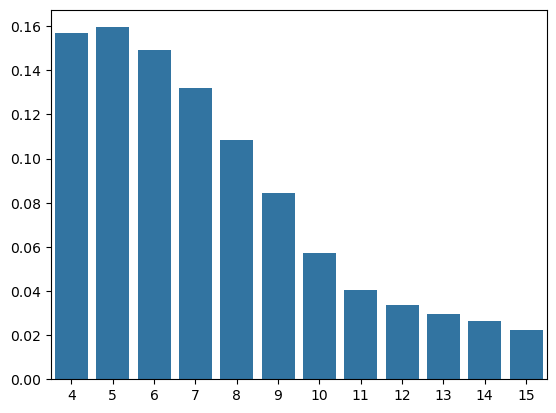

In [79]:
# Plot the distribution
sns.barplot(x=bins[:-1], y=sentence_distribution)

In [82]:
np.savetxt(
    "sentence_distribution.txt", np.vstack([bins[:-1], sentence_distribution]), fmt="%f"
)

# Analysis Again

But this time, actually use the filled examples to determine the best sentence lenghts (use the csv file)

In [5]:
import pandas as pd
import numpy as np

csv_path = "/home/ducha/Dropbox/Tiếng Việt/Ngữ Vựng/Ngữ Vựng_filled.csv"

vocab = pd.read_csv(csv_path, sep=";", header=None)

In [6]:
ex_csv = vocab[2][vocab[2].notna()]
ex_lens = ex_csv.str.split().apply(len)

ex_lens.mean(), ex_lens.std(), ex_lens.min(), ex_lens.max(), ex_lens.shape

(12.401826484018265, 5.708772932230922, 1, 32, (219,))

<Axes: xlabel='2', ylabel='Count'>

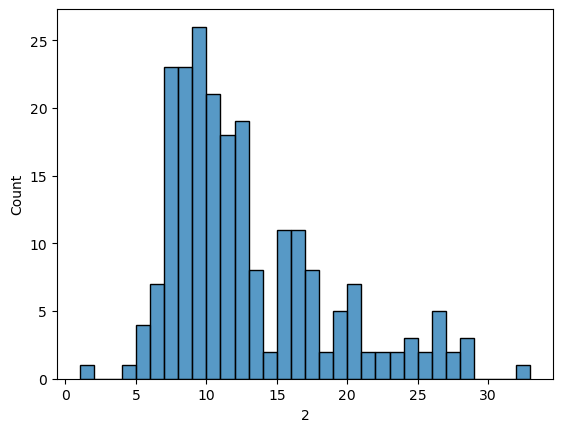

In [7]:
import seaborn as sns

sns.histplot(ex_lens, bins=range(ex_lens.min(), ex_lens.max() + 2))

In [20]:
lower_bound, upper_bound = int(np.percentile(ex_lens, 20)), int(
    np.percentile(ex_lens, 80)
)

In [31]:
in_top_60 = np.logical_and(lower_bound <= ex_lens, ex_lens <= upper_bound)
top_60 = ex_lens[in_top_60]

In [32]:
lower_bound, upper_bound

(8, 16)

<Axes: xlabel='2', ylabel='Count'>

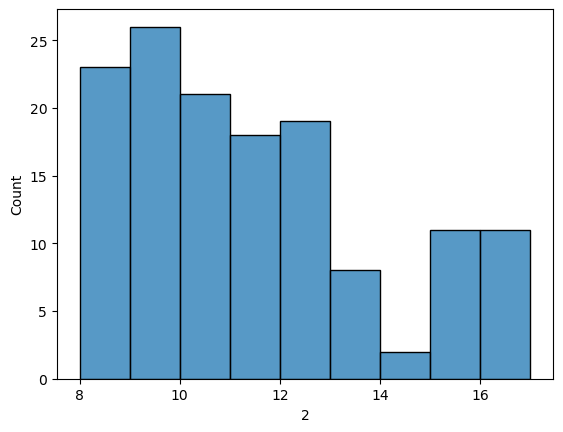

In [42]:
bins = range(lower_bound, upper_bound + 2)
sns.histplot(top_60, bins=bins)

<Axes: >

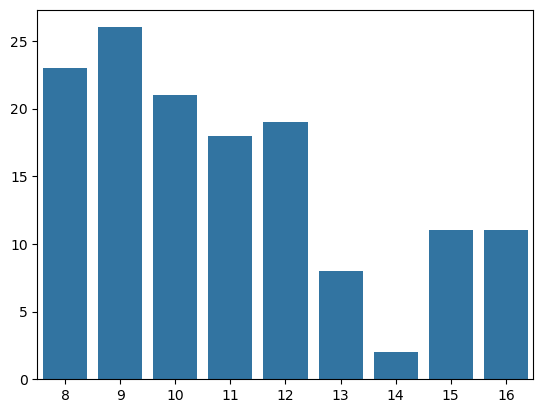

In [48]:
counts, bins = np.histogram(top_60, bins=bins, density=False)

sns.barplot(x=bins[:-1], y=counts)

In [69]:
smoothing = 5
counts_smoothed = counts[:-2] + smoothing
distribution = counts_smoothed / counts_smoothed.sum()
distribution_bins = bins[:-3]
distribution, distribution_bins

(array([0.18421053, 0.20394737, 0.17105263, 0.15131579, 0.15789474,
        0.08552632, 0.04605263]),
 array([ 8,  9, 10, 11, 12, 13, 14]))

<Axes: >

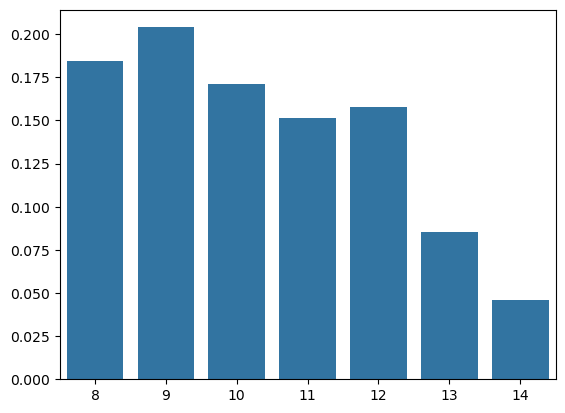

In [70]:
sns.barplot(x=distribution_bins, y=distribution)

In [94]:
# save as 32 bit float
np.save(
    "example_distribution",
    np.vstack([distribution_bins, distribution]).astype(np.float32).T,
)

In [90]:
# Sample from the distribution
n_samples = 5
samples = np.random.choice(
    distribution_bins, size=n_samples, p=distribution, replace=True
)

In [89]:
samples

array([13,  9, 12, 10,  8])